# Geometric Learning of Canonical Parameterizations of 2D-curves: a Python implementation

## 1. Summary

Most datasets encountered in computer vision and medical applications present symmetries that should be taken into account in classification tasks. We present a method to mod out symmetries based on the notion of a principal fiber bundle. This framework allows the use of simple metrics on the space of objects in order to measure dissimilarities between orbits of objects under the symmetry group. We illustrate this methodology on a dataset of contours of objects for the groups of **translations**, **rotations**, **scalings** and **reparameterizations**. In particular, we present a 2-parameter family of canonical parameterizations as a special case, which we believe is interesting in its own right. We hope that this simple application will serve to convey the geometric concepts underlying this method, which have a wide range of possible applications. 

The mathematical background and the algorithms necessary for developing this framework are discussed in [Tumpach 25]. We present here a Python implementation of the method presented in the paper. 

## 2. Database and pre-processing steps

We use the dataset of Swedish leaves from the Linkopling University, which can be freely downloaded from __[https://www.cvl.isy.liu.se/en/research/datasets/swedish-leaf/](https://www.cvl.isy.liu.se/en/research/datasets/swedish-leaf/)__. This dataset consists in pictures of leaves organized into 15 classes, each class containing 75 leaves of the same variety. An element of each class is illustrated in the first column of the table below; the names of the corresponding varieties are listed in the second column. In a preliminary step, we extract the contours of the leaves by transforming the pictures into black and white imprints, then extracting the boundaries of the resulting shapes with an appropiate algorithm. In our implementation, this step has been accomplished using the `bwboundaries` function in Matlab. The resulting contours are illustrated in the third column of the table and consist in an ordered set of points along the boundary of the leaves. This ordering gives us an intitial parameterization $\gamma$ of each contour. 

<table><tr>
<td><center><img src = "leaf.png" style = "width: 250px"> <br>
<i>A sample image from each class of
leaves is depicted (the classes are ordered from left to right and top to bottom)</i>
<td><center><img src = "Leaves_classes.png" style = "width: 250px"><br>
<i>The names of the corresponding varieties</i>
<td><center><img src = "Boundaries_Swedish_leaves.png" style = "width: 250px"><br>
<i>The contours extracted from the binarized images.</i>


We divide the resulting set of contours into a training set, containing 50 contours from each class, and a testing set containing the remaining contours. In particular, the training set and the testing set are disjoint. The following section of code showcases a selection of contours from the training set. 

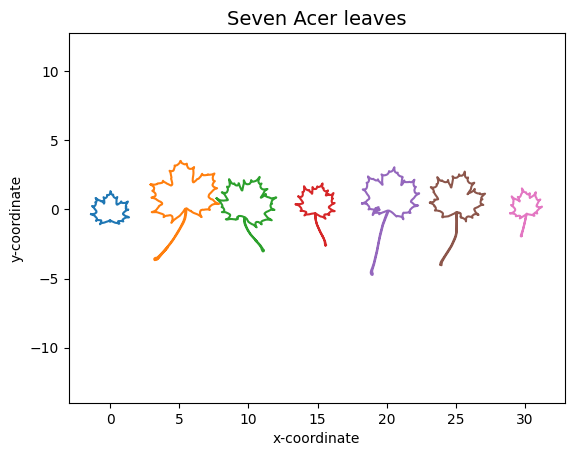

In [1]:
import scipy
import matplotlib.pyplot as plt

#the database is contained in a Matlab .mat file; there are 1125 contours of leaves, each consisting of 1000 points in the plane
path =  r'C:\Users\user1\Documents\geom learning\article\leaves_parameterized.mat'

#load the database using the loadmath function
database = scipy.io.loadmat(path)

#extract the 1125 x 1000 x 2 array from the database variable
leaves = database['leaves_parameterized']

#extract the contours indexed from 75 to 81
n1 = 75
n2 = 82

#plot the contours corressponding to the indices between n1 and n2
font = {'size':14}
for i in range(n1, n2): 
    plt.plot(leaves[i, :, 0]/500 + 5*(i - n1), leaves[i, :, 1]/500)
plt.title('Seven Acer leaves', fontdict = font)
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.axis('equal')
plt.show()

#### 2.1. Standardizing the orientation of contours

The initial parameterizations of the contours obtained from the boundary extraction algorithm induce an arbitrary orientation, leading to contours followed clockwise and contours followed counterclockwise. As a first normalization step, we flip the parameterization of the contours that are followed clockwise. All contours in the resulting dataset are therefore traveled counterclockwise. In order to automatically detect the orientation of a given contour, we compute the signed area enclosed by the contour. A positive signed area corresponds to a contour traveled counterclockwise, and a negative area corresponds to a contour traveled clockwise. The signed area can be computed using Stokes’ Theorem by integration along the contour of a leaf:

\begin{equation*}
    \text{Area}(\gamma) = \int_{\gamma}xdy. 
\end{equation*} 

The following piece of code computes the signed area of a given contour. If the area is negative, then it flips the parameterization so the contour is traveled clockwise. 

In [2]:
import numpy as np

#a function that receives a curve as parameter and returns the area enclosed by it using Stokes' theorem
def compute_area_stokes(curve):

    #N is the number of points in the parameterization
    N = curve.shape[0]

    area = 0
    for i in range(N - 1):
        #compute the integral multiplying the x-coordinate of a given point with the difference between the y-coordinate of its successor and predecessor
        area += curve[i, 0]*(curve[i + 1, 1] - curve[i - 1, 1])/2
        
    area += curve[N - 1, 0]*(curve[0, 1] - curve[N - 2, 1])/2

    return area

leaf = leaves[n1, :, :]
area = compute_area_stokes(leaf)
print("area = \n", area)
if area < 0:
    print("leaf is parameterized clockwise")
    leaf = np.flipud(leaf)
    print("area of the flipped curve = \n", compute_area_stokes(leaf))
else:
    print("leaf is parameterized counter-clockwise")

area = 
 -860180.9043197355
leaf is parameterized clockwise
area of the flipped curve = 
 860180.9043197366


#### 2.2. Standardizing the starting point of parameterizations

Since the contour of a leaf is represented by an ordered set consisting in finitely many sample points along the contour, the starting point of this discretization induces variability that we need to take into account. For the dataset of leaves at hand, we detect the point of each contour with the largest vertical component (which is unique for all contours), i.e. the "northernmost" point, and reorder the sample points in such a way that this particular point becomes the starting point. The section of the code below finds the point with the largest Y-coordinate in the set and rearranges the order such that this point has index 0 in the array. 

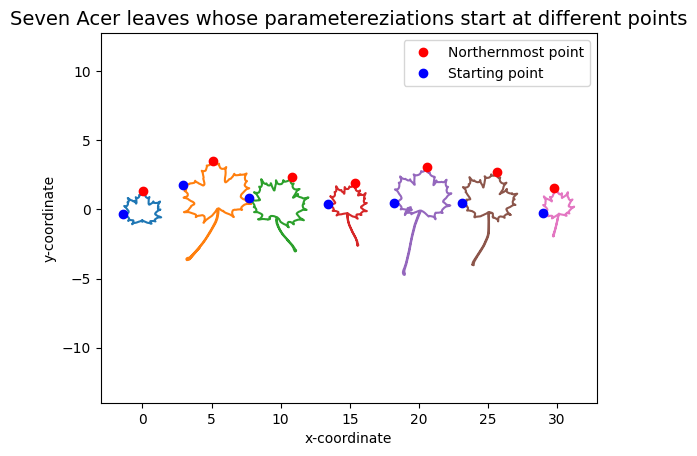

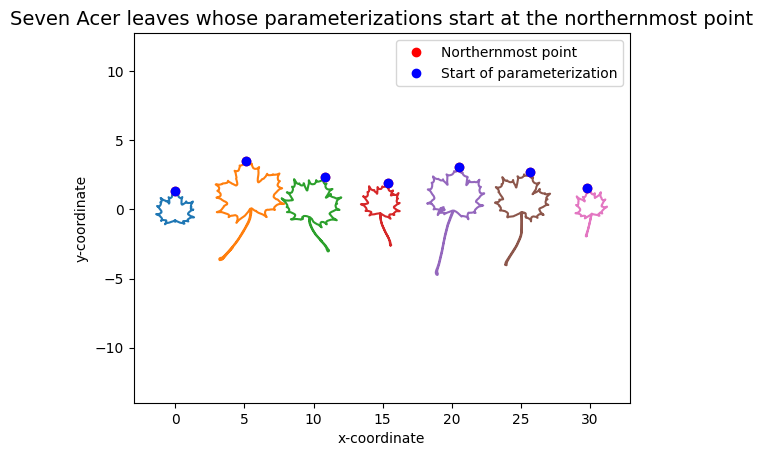

In [3]:
import geomstats.backend as gs

def get_max_y_and_roll(curve):

    #get the index of the point with the largest Y-coordinate in the parameterization of the curve
    max_y_coord = gs.argmax(curve[:,1])

    #shift the coordinates of the parameterization to the left by max_y_coord places
    curve = np.roll(curve, -max_y_coord, axis=0)

    return curve

#plot the contour of seven leaves, the northernmost point in their parameterizations and the starting point of their parameterization
for i in range(n1, n2):
    leaf = leaves[i, :, :]
    plt.plot(leaf[:, 0]/500 + 5*(i - n1), leaf[:, 1]/500)
    max_y = np.max(leaf[:,1])
    max_x = float(leaf[np.where(leaf[:, 1] == max_y)[0], 0])
    line1, = plt.plot(max_x/500 + 5*(i - n1), max_y/500, 'ro', label = 'Northernmost point')
    line2, = plt.plot(leaf[0, 0]/500 + 5*(i - n1), leaf[0, 1]/500, 'bo', label = 'Starting point')

plt.title('Seven Acer leaves whose parametereziations start at different points', fontdict = font)
plt.legend(handles = [line1, line2])
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.axis('equal')
plt.show()

#rearrange the points in the parameterization such that the red dots and blue dots coincide, then plot the contour, norhternmost point and starting point
for i in range(n1, n2):
    leaf = leaves[i, :, :]
    rolled_leaf = get_max_y_and_roll(leaf)
    max_y = np.max(rolled_leaf[:,1])
    max_x = float(rolled_leaf[np.where(rolled_leaf[:, 1] == max_y)[0], 0])
    plt.plot(rolled_leaf[:, 0]/500 + 5*(i - n1), rolled_leaf[:, 1]/500)
    line1, = plt.plot(max_x/500 + 5*(i - n1), max_y/500, 'ro', label = 'Northernmost point')
    line2, = plt.plot(rolled_leaf[0, 0]/500 + 5*(i - n1), rolled_leaf[0, 1]/500, 'bo', label = 'Start of parameterization')

plt.title('Seven Acer leaves whose parameterizations start at the northernmost point', fontdict = font)
plt.legend(handles = [line1, line2])
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.axis('equal')
plt.show()


We remark that in the second figure the blue dot and red dot are overlayed, hence only one of them is visible. 

#### 2.3. Standardizing the scale variability

The dataset contains leaves of different sizes, as can be seen in the figure below.

![alt text](<seven acer leaves-1.png>)

In order to recognize the class of a leaf irrespective of its size, we need to eliminate the variability of the scale. We tested two normalization procedures. 


**a. Normalization of the length of contours**: in this normalization method, we first compute the contour length of each leaf and then divide the initial parameterization by this length. A python implementation is given in the code below. 

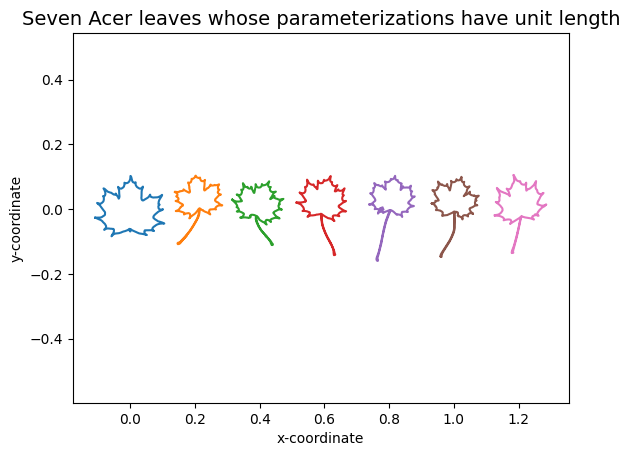

In [4]:
#normalize a contour 
def curve_unit_length(curve) -> np.array:
    length = 0
    for i in range(curve.shape[0] - 1):
        #compute length by successively adding the Eucliden distance between two adjacent points in the parameterization
        length += gs.linalg.norm(curve[i + 1, :] - curve[i, :])
    
    normalized_curve = curve/length
    return normalized_curve

for i in range(n1, n2):
    leaf = curve_unit_length(leaves[i, :, :])
    plt.plot(leaf[:, 0] + 0.2*(i - n1), leaf[:, 1])

plt.title('Seven Acer leaves whose parameterizations have unit length', fontdict = font)
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.axis('equal')
plt.show()

We remark that normalization by unit-length is heavily affected by the presence of absence of a peduncle.

**b. Normalization of the enclosed area:** each contour is a Jordan curve (i.e. closed and with no self-intersections) in the plane and encloses a domain which corresponds to the surface of the corresponding leaf. In this normalization step, we compute the area of each leaf and renormalize the initial parameterization to have a unit area by dividing the parameterization by the square-root of (the absolute value of) the area. A Python implementation is given in the code below. 

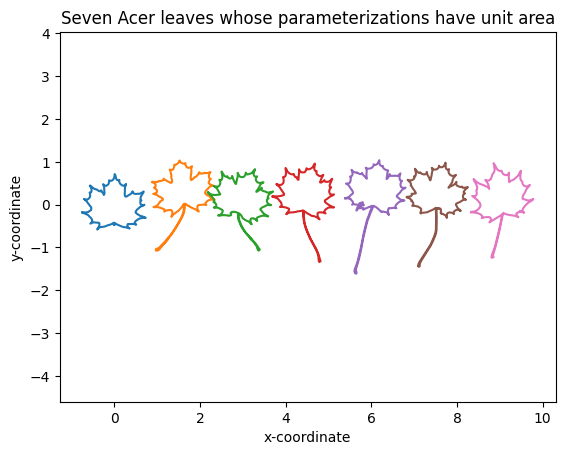

In [5]:
def scale_unit_area(curve) -> np.array:
    
    #compute the area using Stokes' theore and take the absolute value
    area = np.abs(compute_area_stokes(curve))
    #divide the parameterization by the square root of the area
    scaled_curve = curve/np.sqrt(area)

    return scaled_curve

for i in range(n1, n2):
    leaf = scale_unit_area(leaves[i, :, :])
    plt.plot(leaf[:, 0] + 1.5*(i - n1), leaf[:, 1])

plt.title('Seven Acer leaves whose parameterizations have unit area')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.axis('equal')
plt.show()

We remark that the normalization to curves with unit-enclosed area is not affected by the presence or absence of peduncles, since peduncles barely contribute to the area. 

#### 2.4. Standardizing the position in space
The shape of a leaf is invariant by translation in space. We have tested three normalization procedures that can be used to eliminate the variability in positions.

The section of code below plots a sequence of leaves highlighting the fact that the positions of the first points of the parameterizations, the centers of mass of the contours, and the centers of mass of the enclosed areas are different. In this experiment, the initial parameterization is counterclockwise, the starting point of each parameterized curve coincides with the point of the contour with the largest vertical coordinate and the scaling is by unit length. The coordinates of the center of mass of the contour are computed as the mean of the coordinates of points visited by the initial parameterization $\gamma(s) = (x(s), y(s))$:
\begin{equation*}
    \begin{array}{l}
    \bar{x} = \frac{1}{\operatorname{Length}(\gamma)}\int_0^1 x(s) \|\gamma'(s)\|ds\\
    \bar{y} = \frac{1}{\operatorname{Length}(\gamma)}\int_0^1 y(s) \|\gamma'(s)\|ds\\
    \end{array}. 
\end{equation*}
The coordinates $(\hat{x}, \hat{y})$ of the center of mass of the surface (i.e. the center of gravity of the leaf) are computed by using Stokes theorem:
\begin{equation*}
    \begin{array}{l}
    \hat{x} = \frac{1}{2\operatorname{area}(\gamma)}\int_\gamma x^2 dy\\
    \hat{y} = -\frac{1}{2\operatorname{area}(\gamma)}\int_\gamma y^2 dx\\
    \end{array}. 
\end{equation*}

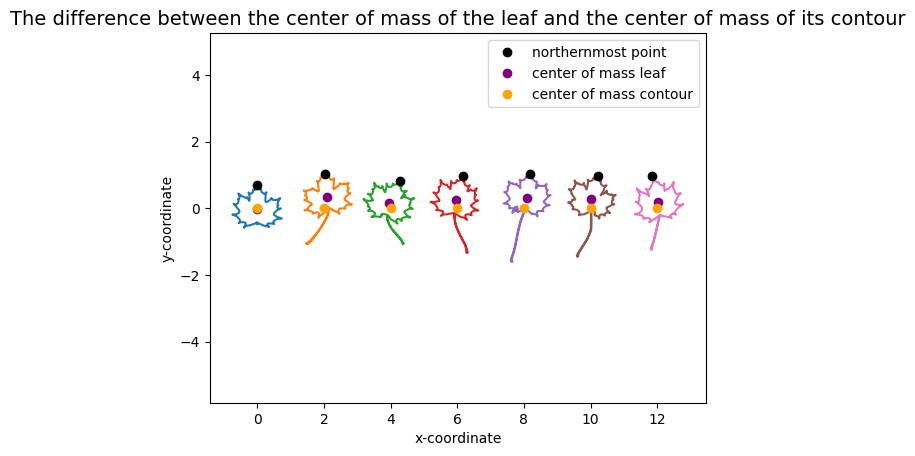

In [6]:

#computes the center of mass of the surface of the leaf (the center of gravity)
def compute_center_of_mass(curve):
    
    cx = 0
    cy = 0
    area = compute_area_stokes(curve)

    for i in range(len(curve) - 1):
        integral_contribution_x = 0.5*gs.power(curve[i, 0], 2) * (curve[i + 1, 1] - curve[i, 1])
        integral_contribution_y = 0.5*gs.power(curve[i, 1], 2) * (curve[i + 1, 0] - curve[i, 0])
        cx += (integral_contribution_x ) / area
        cy += (-integral_contribution_y ) / area
    return gs.array([cx, cy])

for i in range(n1, n2):
    #scale the parameterization by unit length
    leaf = scale_unit_area(leaves[i, :, :])
    
    #make sure the parameterization if counterclockwise
    if compute_area_stokes(leaf) < 0:
        leaf = np.flipud(leaf)

    #reorder the points of the parameterization such that the northernmost point is the starting point
    rolled_leaf = get_max_y_and_roll(leaf)

    #compute the center of mass of the surface of the leaf
    center_of_mass = compute_center_of_mass(rolled_leaf)

    #compute the center of mass of the contour
    center_of_contour = gs.array([np.mean(rolled_leaf[:, 0]), np.mean(rolled_leaf[:, 1])])

    #plot the leaf, the northernmost point, the center of mass of the surface and the center of mass of the contour
    plt.plot(rolled_leaf[:, 0] + 2*(i - n1), rolled_leaf[:, 1])
    line1, = plt.plot(rolled_leaf[0, 0] + 2*(i - n1), rolled_leaf[0, 1], 'o', color = 'black', label = 'northernmost point')
    line2, = plt.plot(center_of_mass[0] + 2*(i - n1), center_of_mass[1], 'o', color = 'purple', label = 'center of mass leaf')
    line3, = plt.plot(center_of_contour[0] + 2*(i - n1), center_of_contour[1], 'o', color = 'orange', label = 'center of mass contour')

plt.title('The difference between the center of mass of the leaf and the center of mass of its contour', fontdict=font)
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.legend(handles = [line1, line2, line3])
plt.axis('equal')
plt.show()

**a. Starting point at the origin**: for this normalization method, we simply substract the coordinates of the first point visited by the initial parameterized contour, leading to a parameterized curve starting at $(0,0)\in\mathbb{R}^2$.

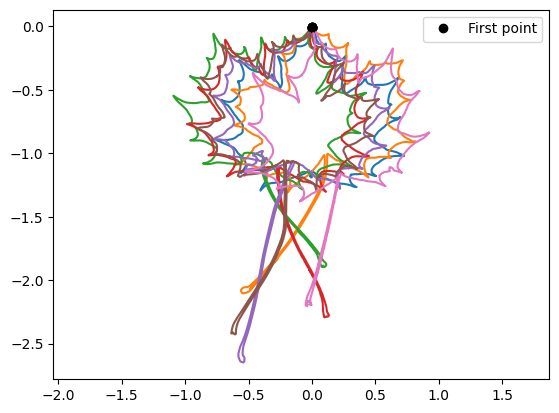

In [7]:
for i in range(n1, n2):

    #scale contour by area
    leaf = scale_unit_area(leaves[i, :, :])

    #set the starting point as the northernmost point
    rolled_leaf = get_max_y_and_roll(leaf)

    #get the coordinates of the first point
    center = gs.array([rolled_leaf[0, 0], rolled_leaf[0, 1]])
    plt.plot(rolled_leaf[:, 0] - center[0], rolled_leaf[:, 1] - center[1])
    line1, = plt.plot((rolled_leaf[:, 0] - center[0])[0], (rolled_leaf[:, 1] - center[1])[1], 'o', color = 'black', label = 'First point')

plt.legend(handles = [line1])
plt.axis('equal')
plt.show()


**b. Center of mass of the contour at the origin**: in this normalization method, we compute the coordinates $(\bar{x}, \bar{y})$ of the center of mass of the contour as the mean of the coordinated of points visited by the initial parameterization $\gamma(s) = (x(s), y(s))$:
\begin{equation*}
    \begin{array}{l}
    \bar{x} = \frac{1}{\operatorname{Length}(\gamma)}\int_0^1 x(s) \|\gamma'(s)\|ds\\
    \bar{y} = \frac{1}{\operatorname{Length}(\gamma)}\int_0^1 y(s) \|\gamma'(s)\|ds\\
    \end{array}
\end{equation*}
and then we substract the coordinates of this center of mass from the initial parameterization.

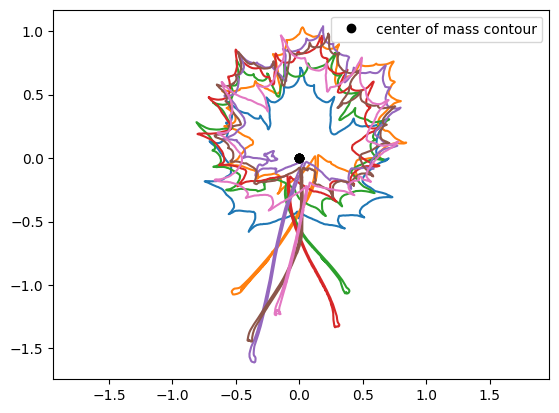

In [8]:
for i in range(n1, n2):

    #scale the contour by area
    leaf = scale_unit_area(leaves[i, :, :])

    #set the starting point of the parameterization as the northernmost point
    rolled_leaf = get_max_y_and_roll(leaf)

    #compute the coordinates of the center of mass
    center = gs.array([np.mean(leaf[:, 0]), np.mean(leaf[:, 1])])

    #translate the curve
    translated_leaf = rolled_leaf - center
    plt.plot(translated_leaf[:, 0], translated_leaf[:, 1])

    #compute center of mass for the translated contour: should be (0, 0) for all contours
    new_center = gs.array([np.mean(translated_leaf[:, 0]), np.mean(translated_leaf[:, 1])])
    line1, = plt.plot(new_center[0], new_center[1], 'o', color = 'black', label = 'center of mass contour')

plt.legend(handles = [line1])
plt.axis('equal')
plt.show()

In the figure, the contours are centered so that the center of mass of the contours is at the origin.

**c. Center of gravity of the enclosed area at the origin**: in this normalization method, we compute the coordinated $(\hat{x}, \hat{y})$ of the center of gravity of the area enclosed by the contour (i.e. of the surface of the corresponding leaf) by using Stokes theorem:
\begin{equation*}
    \begin{array}{l}
    \hat{x} = \frac{1}{2\operatorname{area}(\gamma)}\int_\gamma x^2 dy\\
    \hat{y} = -\frac{1}{2\operatorname{area}(\gamma)}\int_\gamma y^2 dx\\
    \end{array}
\end{equation*}
and then we substract the coordinates of this center of gravity from the initial parameterization.

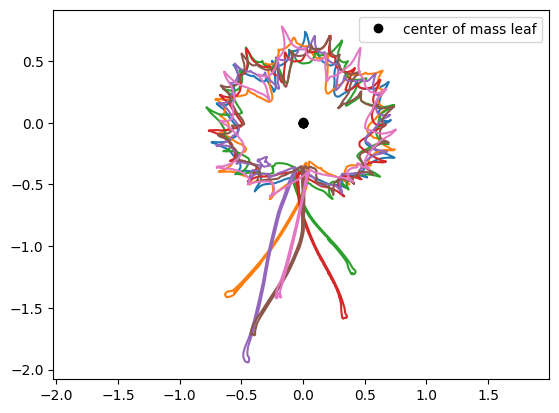

In [9]:
for i in range(n1, n2):

    #scale the contour by area
    leaf = scale_unit_area(leaves[i, :, :])

    #set the starting point as the northernmost point
    rolled_leaf = get_max_y_and_roll(leaf)

    #compute the coordinates of the center of mass
    center_of_mass = compute_center_of_mass(leaf)

    #translate the contour
    translated_leaf = leaf - center_of_mass
    plt.plot(translated_leaf[:, 0], translated_leaf[:, 1])

    #compute the center of mass of the translated contour: should be (0, 0) for all contours
    new_center_mass = compute_center_of_mass(translated_leaf)
    line1, = plt.plot(new_center_mass[0], new_center_mass[1], 'o', color = 'black', label = 'center of mass leaf')

plt.legend(handles = [line1])
plt.axis('equal')
plt.show()

In the figure, the contours are centered so that the center of gravity of the enclosed area is at the origin.
One can see that the length of the peduncle influences the position of the center of mass of the contour, but not the position of the center of gravity of the enclosed area, leading to a better alignment of the contours. 

#### 2.5. Standardizing the orientation in space

The leaves in the dataset we are considering have different orientations in space and need to be rotated in a consistent way to eliminate the orientation variability. We have tested two normalization procedures to align the orientations through the dataset.

**a. Axes of the approximating ellipse aligned**: each contour is rotated so that the ellipse that best approximates the contour has its minor axis along the horizontal axis, and its major axis vertically. We did not encounter contours with equal minor and major axes.

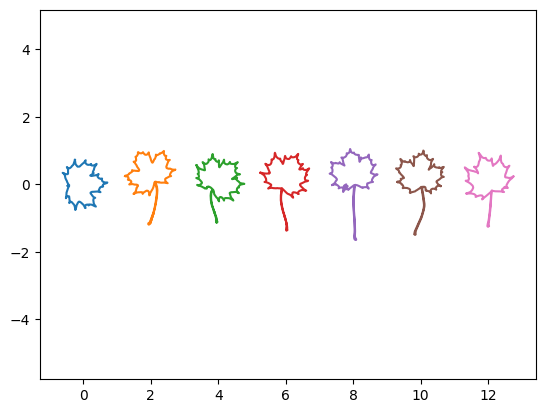

In [10]:
from sklearn.decomposition import PCA

def rotate_curve_major_vertical(curve):
    
    mean = gs.mean(curve, axis=0)
    centered = curve - mean

    pca = PCA(n_components=2)
    pca.fit(centered)
    components = pca.components_
    variances = pca.explained_variance_

    major_idx = gs.argmax(variances)
    minor_idx = 1 - major_idx

    R = gs.vstack([components[minor_idx], components[major_idx]])

    #ensure right-handed orientation (det = +1)
    if gs.linalg.det(R) < 0:
        #flip the major axis
        R[1, :] *= -1   

    #apply rotation
    rotated_curve = centered @ R.T

    return rotated_curve

for i in range(n1, n2):
    leaf = scale_unit_area(leaves[i, :, :])
    rotated_leaf = rotate_curve_major_vertical(leaf)
    plt.plot(rotated_leaf[:, 0] + 2*(i - n1), rotated_leaf[:, 1])

plt.axis('equal')
plt.show()

This normalization method does not lead to good results due to the presence of leaves with peduncle and leaves without peduncle in the same class. As can be seen in the figure on the example of Acer leaves, the alignment of the major and minor axis of the approximating ellipse leads to inconsistent orientation of the leaf without peduncle with respect to the other leaves. 

**b. Segment joining the tip of the leaf to the center of the enclosed area is placed vertically**: each contour is rotated so as to position the center of the enclosed area vertically below the highest point of the contour.

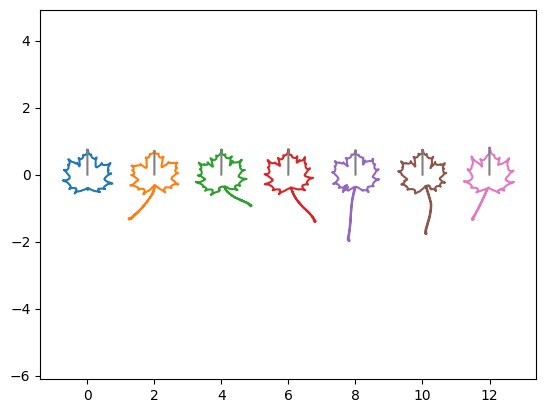

In [ ]:
def translate_center_of_mass(curve):
    
    center_of_mass = compute_center_of_mass(curve)
    translated_curve = curve - center_of_mass
    return translated_curve

def rotate_axis(curve) -> gs.array:

    curve = translate_center_of_mass(curve)
    #computing the segment defined by the point with the highest y-component and the origin
    vector = curve[gs.argmax(curve[:, 1]), :]
    #normalize this segment
    n_vector = vector/gs.sqrt(gs.power(vector[0],2) + gs.power(vector[1], 2))
    x = n_vector[0]
    y = n_vector[1]
    rotation_matrix = gs.array([[y, -x], [x, y]])
    curve_rotated_axis = (rotation_matrix @ curve.T).T

    return curve_rotated_axis

for i in range(n1, n2):
    leaf = scale_unit_area(leaves[i, :, :])
    rolled_leaf = get_max_y_and_roll(leaf)
    rotated_leaf = rotate_axis(rolled_leaf)
    plt.plot(rotated_leaf[:, 0] + 2*(i - n1), rotated_leaf[:, 1])
    center_of_mass = compute_center_of_mass(rotated_leaf)
    max_y = np.max(rotated_leaf[:,1])
    max_x = float(rotated_leaf[np.where(rotated_leaf[:, 1] == max_y)[0], 0])
    plt.plot([center_of_mass[0] + 2*(i - n1), max_x  + 2*(i - n1)], [center_of_mass[1], max_y], color = 'grey')

plt.axis('equal')
plt.show()


The second normalization method gives better results, as seen in the figure. We will choose this second normalization method, in order to normalize the orientation variability and obtain consistent classification results.

## 3. Clock parameterization

In this section, we introduce a new canonical parameterization of simple plane curves, called the clock parameterization. We will make use of the analogy with a traditional clock to explain how this parameterization is constructed. Suppose that we have $720= 12\times 60$ points to place along the contour of the Acer leaf. If we place 720 points uniformly along the contour and cut the enclosed area as a pizza from its center of gravity to the points corresponding to a multiple of 60, then we get 12 pieces of different angles. This is illustrated in the figure below by a change of color every 60 points.

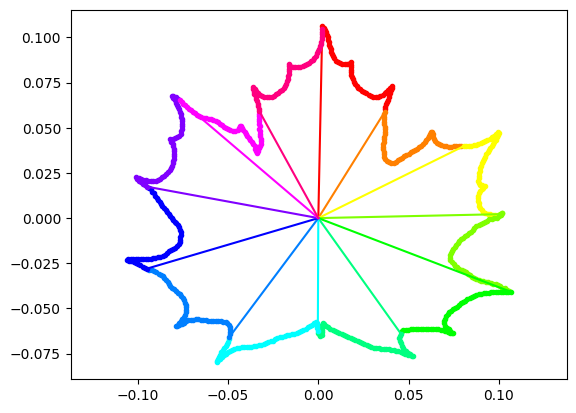

In [18]:
#we use interpolation to redistribute the points along the contour when we go from the original 1000 points to 720
from  scipy.interpolate import interp1d

def compute_length(curve):

    length = 0
    for i in range(curve.shape[0] - 1):
        length += gs.linalg.norm(curve[i + 1, :] - curve[i, :])
    return length

def curve_unite_length(curve) -> np.array:
    
    length = compute_length(curve)
    normalized_curve = curve/length
    return normalized_curve

#we reparameterize the contour to consist of 720 points, using the arc-length parameterization
def reparametrize_by_arc_length(curve, N, normalized = True):

    dim = curve.shape[1]
    length = compute_length(curve)
    deltas = gs.linalg.norm(np.diff(curve, axis = 0), axis = 1) + 1e-6
    deltas = np.insert(deltas, 0, 0.0)

    #the given set of points for the interpolation
    cumdelta = gs.cumsum(deltas)

    #the new set of points for the interpolated function
    if normalized:
        cumdelta = cumdelta/length
        newdelta = gs.linspace(0, 1, N)
    else:
        newdelta = gs.linspace(0, length, N) 

    #we use linear interpolation to obtain the values of the function (parameterization) in the new points
    arc_length_parametrized_curve = gs.zeros((N, dim))
    for i in range(dim):
        arc_length_parametrized_curve[:, i] = interp1d(cumdelta, curve[:, i], kind="linear", fill_value="extrapolate")(newdelta)
    
    return arc_length_parametrized_curve

#A function for assigning colors to points
def colorbar_rainbow(u):
    
    # Scale u to range [1, 1530]
    x = gs.array(u) * 1529 + 1
    
    r = gs.zeros_like(x, dtype=float)
    g = gs.zeros_like(x, dtype=float)
    b = gs.zeros_like(x, dtype=float)
    
    # Red → Yellow
    mask = (x >= 0) & (x < 255)
    r[mask] = 255
    g[mask] = x[mask]
    b[mask] = 0
    
    # Yellow → Green
    mask = (x >= 255) & (x < 510)
    r[mask] = 510 - x[mask]
    g[mask] = 255
    b[mask] = 0
    
    # Green → Cyan
    mask = (x >= 510) & (x < 765)
    r[mask] = 0
    g[mask] = 255
    b[mask] = x[mask] - 510
    
    # Cyan → Blue
    mask = (x >= 765) & (x < 1020)
    r[mask] = 0
    g[mask] = 1020 - x[mask]
    b[mask] = 255
    
    # Blue → Magenta
    mask = (x >= 1020) & (x < 1275)
    r[mask] = x[mask] - 1020
    g[mask] = 0
    b[mask] = 255
    
    # Magenta → Red
    mask = (x >= 1275) & (x <= 1530)
    r[mask] = 255
    g[mask] = 0
    b[mask] = 1530 - x[mask]
    
    # Normalize to [0,1]
    R = r / 255
    G = g / 255
    B = b / 255
    
    # Stack to RGB
    col = gs.stack([R, G, B], axis=-1)
    
    return col

leaf = leaves[75, :, :]

#normalizer steps: 
#   rescale the leaf so it has unit length
#   rearrange the points of the parameterization so the first point is also the northernmost
#   translate the leaf so the center of mass is at the origin
leaf = curve_unite_length(leaf)
leaf = get_max_y_and_roll(leaf)
leaf = translate_center_of_mass(leaf)

N = 720

#reparametrization by arc length; the new parameterization has 720 points
new_leaf = reparametrize_by_arc_length(leaf, N)

#the number of sections (subdivisions) must be a divisor of N
sections = 12
step = int(N / sections)
    
j = 0
for i in range(0, 720, step):
    k = i + step
    plt.plot(new_leaf[j:k, 0], new_leaf[j:k, 1], '.', color = colorbar_rainbow(i/720))
    plt.plot([0, new_leaf[j, 0]], [0, new_leaf[j, 1]], color = colorbar_rainbow(i/720))
    j = k
        
plt.axis('equal')
plt.show()


In contrast, the clock parameterization places automatically each point numbered by a multiple of 60 in such a way that the corresponding angle is precisely 360/12 degrees, hence at the positions of the hours on a traditional clock. To place these 12 keypoints at the hours positions, we compute the angle between the vertical line and the segment connecting the center of gravity to a point traveling along the contour at constant speed. The clock parameterization is illustrated in the first figure. 


The graph of the angle function for the Acer leaf is illustrated in the second figure. It allows to detect the constant speed parameter of the first point reaching an angle multiple of 360/12 degrees. The horizontal lines are spaced every 360/12 degrees and hit the graph of the angle function at precisely these constant speed parameters. Between two consecutive points having these particular constant speed parameters, we distribute exactly 60 points uniformly along the portion of the curve between them. The resulting reparameterization of the Acer leaf is such that each colored portion of the curve describes the same angle with respect to the center of gravity, and contains exactly the same number of points.


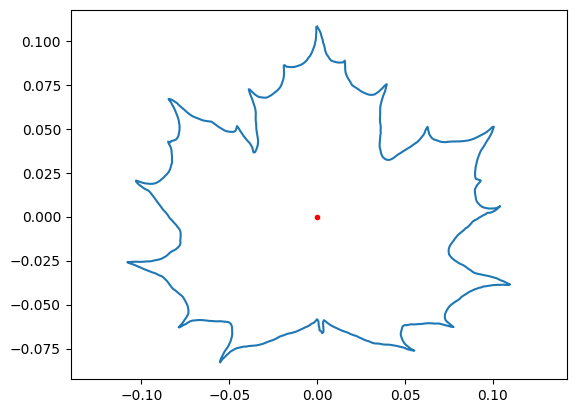

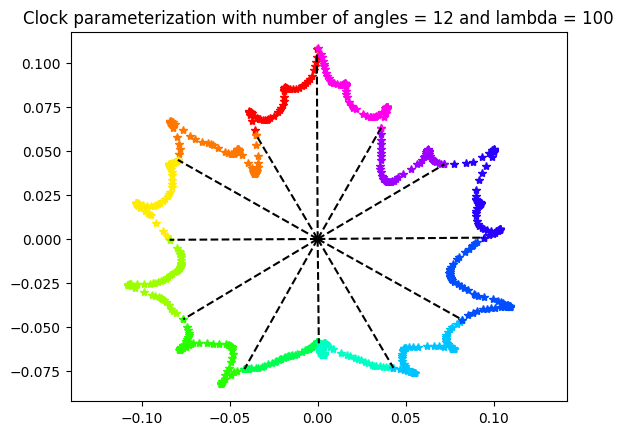

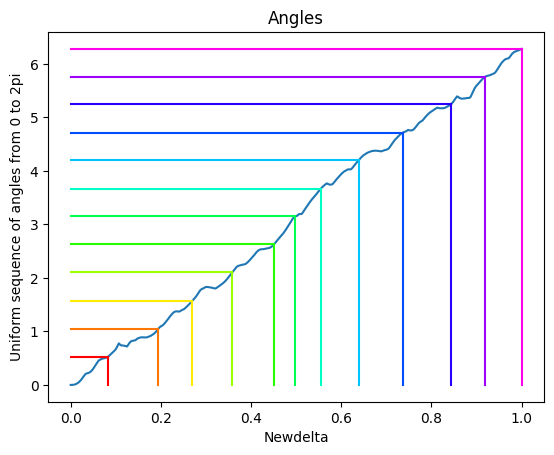

In [13]:
import matplotlib.path as mpltPath

#A function that computes the angles determined by each pair of adjacent points in the parameterization
def extract_angle_sequence(curve):
    
    nb_frames, dim = curve.shape
    unite_curve = gs.zeros((nb_frames, dim))

    #normalize the curve: the segments connecting the origin of the plane to the points on the curve must me equal in length
    for i in range(nb_frames):
        unite_curve[i,:] = curve[i,:] / (gs.linalg.norm(curve[i, :]))
    
    n = gs.zeros(2)

    #compute the sequence of angles
    angles = gs.zeros(nb_frames)
    for i in range(1, nb_frames, 1):
        angle_vert = unite_curve[i,:] - gs.dot(unite_curve[i, :], unite_curve[i-1, :])*unite_curve[i-1, :]
        n[0] = - unite_curve[i-1,1]
        n[1] = unite_curve[i-1,0]
        sinus_angle = gs.dot(angle_vert, n)
        dot_val = gs.dot(unite_curve[i, :], unite_curve[i-1, :])
        dot_val = np.clip(dot_val, -1.0, 1.0)  #This is added to avoid numerical errors
        if sinus_angle >= 0:
            angles[i] = angles[i-1] + gs.arccos(dot_val)
        else:
            angles[i] = angles[i-1] - gs.arccos(dot_val)
    if any(np.isnan(angles)):
        raise ValueError("Something wrong happened during the arcosine calculus.")
    return angles

#A function that creates an array of indices corresponding to points uniformly distributed with respect to the angles between them
def extract_uniform_angles(a, angles):
    
    a = a + 1

    nb_frames = angles.shape[0]
    angles_uniform = gs.zeros(a - 1)
    indices = gs.zeros(a, dtype = int)
    indices[0] = 0

    #a uniform sequence a angles from 0 to 2pi
    for s in range(a - 1):
        angles_uniform[s] = angles[0] + (s + 1) * 2 * np.pi / (a - 1)
    
    #for each angle i in the uniform angle sequence, find the first point in the parameterization that, together with the starting point, determines an angle greater than i
    j = 0
    for i in range(1, nb_frames - 1, 1):
        if np.max(angles[:i + 1]) > angles_uniform[j]:
            indices[j + 1] = i
            if j == angles_uniform.shape[0] - 1:
                break
            else:
                j += 1
        
    indices[-1] = nb_frames-1

    return indices

#A function that reparameterizes a segement of the curve proportionally to the curvature
def reparametrize_by_curvature(curve, lmbda = 1, unif_subset = 12):
    
    _,dim = curve.shape
    length = compute_length(curve)
    newdelta = np.linspace(0, 1, unif_subset)
    f_seconde = gs.zeros(curve.shape)

    #we compute the second derivative of the parameterization at each point
    for i in range(2):
        for j in range (1, unif_subset - 1, 1):
            f_seconde[j, i] = (
                curve[j + 1, i] - 2 * curve[j, i] + curve[j - 1,i]) * (gs.power((unif_subset - 1), 2) / (length**2))
        f_seconde[0,i] = 0
        f_seconde[-1,i] = 0

    #the curvature at a point is the norm of the acceleration vector at that point (i.e. the second derivative of the parameterization at that point)
    curvature = gs.linalg.norm(f_seconde, axis = 1)
    curvedelta = gs.zeros(unif_subset)

    weights = lmbda*length + curvature

    #we compute the total curvature by integrating the curvature function along the length of the curve
    total_curve_arc_length = np.trapz(weights, newdelta)

    #the given set of points for the interpolation
    for s in range(1, unif_subset, 1):
        curvedelta[s - 1] = np.trapz(weights[:s], newdelta[:s]) / total_curve_arc_length
    curvedelta[-1] = 1.0

    #the set of points for the interpolated function
    newcurvedelta = gs.linspace(0, 1, unif_subset)
    function_parametrized_prop_to_curv_arc_length = gs.zeros((unif_subset, dim))

    #the reparameterization is computed by linear interpolation
    for i in range(dim):
        inter_func2 = interp1d(curvedelta, curve[:, i], kind = 'linear', fill_value = "extrapolate")
        function_parametrized_prop_to_curv_arc_length[:, i] = inter_func2(newcurvedelta)

    return function_parametrized_prop_to_curv_arc_length

#A function that reparameterizes a curve by a "clock" type parameterization
def projection_clock_a_lmbda(curve, n_subdivision = 12, lmbda = None, visualize = False):
    
    n_frame, dim = curve.shape

    #the set of points for the interpolated function
    newdelta = np.linspace(0, 1, n_frame)
    
    #we make sure the curve is traveled counterclockwise
    if compute_area_stokes(curve) < 0: 
        curve = np.flipud(curve)
    
    #compute the angles between each pair of points on the curve
    angles = extract_angle_sequence(curve)

    #extract the indices of the points that most closely match the uniform distribution of the angles
    indices = extract_uniform_angles(n_subdivision, angles) 

    clock_param_fun_a = gs.zeros((n_frame, dim))
    clock_param_fun_a_lambda = gs.zeros((n_frame, dim))
    
    unif_subset = int(np.floor(n_frame / n_subdivision))
    
    #we use this variable to record the colors used when plotting the sections of the contour
    cl = np.zeros(len(indices))
    
    for k in range(len(indices) - 1):
        #take the portion of the parameterization enclosed by an angle
        argument = newdelta[indices[k]:indices[k + 1] + 1]
        #compute the new domain of the parameterization, consisting of uniformly distributed points
        newdel2 = np.linspace(argument[0], argument[-1], num = unif_subset)
        
        #reparameterize the section by the arc-length
        for d in range(dim):
            portion_of_x_or_y = curve[indices[k]:indices[k + 1] + 1, d]
            f_interp = interp1d(argument, portion_of_x_or_y, kind = 'linear') 
            clock_param_fun_a[(k) * unif_subset:(k + 1) * unif_subset, d] = f_interp(newdel2)
        
        cl[k] = k / (len(indices))

        #if lambda is given, reparameterize the section using the curvature weighted parameterization
        if lmbda is not None:
            clock_param_fun_a_lambda[(k) * unif_subset:(k + 1) * unif_subset, :] = reparametrize_by_curvature(clock_param_fun_a[(k) * unif_subset:(k + 1) * unif_subset, :] , lmbda, unif_subset)
        
            if visualize:
                plt.plot(
                    clock_param_fun_a_lambda[(k) * unif_subset: ( k + 1 ) * unif_subset, 0], 
                    clock_param_fun_a_lambda[(k) * unif_subset: ( k + 1 ) * unif_subset, 1],
                    '*',
                    color=colorbar_rainbow(cl[k]))
                #add lines for the subsections
                plt.plot(
                        [0,clock_param_fun_a_lambda[( k ) * unif_subset, 0]],
                        [0,clock_param_fun_a_lambda[( k ) * unif_subset, 1]],
                        'k--')
        
        #if no lambda is given, we use the arc length parameterization, this code is for plotting        
        if lmbda is None and visualize:
            plt.plot(
                    clock_param_fun_a[(k) * unif_subset: ( k + 1 ) * unif_subset, 0], 
                    clock_param_fun_a[(k) * unif_subset: ( k + 1 ) * unif_subset, 1],
                    '*',
                    color=colorbar_rainbow(cl[k]))
            #add lines for the subsections
            plt.plot(
                        [0,clock_param_fun_a[( k ) * unif_subset, 0]],
                        [0,clock_param_fun_a[( k ) * unif_subset, 1]],
                        'k--')
    
    if visualize:
        plt.title(f'Clock parameterization with number of angles = {n_subdivision} and lambda = {lmbda}')
        plt.axis('equal')
        plt.show()

        #plot the angle function
        plt.plot(newdelta, angles)
        j = 0
        for i in range(1, np.shape(indices)[0]):
            plt.plot([newdelta[indices[i]], newdelta[indices[i]]], [0, angles[indices[i]]], color = colorbar_rainbow(cl[i - 1]))
            plt.plot([0, newdelta[indices[i]]], [angles[indices[i]], angles[indices[i]]], color = colorbar_rainbow(cl[i - 1]))
        
        plt.title('Angles')
        plt.xlabel('Newdelta')
        plt.ylabel('Uniform sequence of angles from 0 to 2pi')
        plt.show()

    if lmbda is None:
        return clock_param_fun_a
    else:
        return clock_param_fun_a, clock_param_fun_a_lambda

        
leaf = leaves[75, :, :]

N = 720

#reparametrization by arc length; the new parameterization has N points
leaf = reparametrize_by_arc_length(leaf, N)

#normalizer steps: 
#   rescale the leaf so it has unit length
#   rearrange the points of the parameterization so the first point is also the northernmost
#   translate the leaf so the center of mass is at the origin
leaf = get_max_y_and_roll(leaf)
leaf = curve_unite_length(leaf)
leaf = translate_center_of_mass(leaf)
leaf = rotate_axis(leaf)

plt.plot(leaf[:, 0], leaf[:, 1])
plt.plot(0, 0, '.', color = 'red')
plt.axis('equal')
plt.show()

#the number of subdivisions must be a divisor of N
_,test = projection_clock_a_lmbda(leaf, n_subdivision = 12, lmbda = 100, visualize = True)


## 4. Classification task

Given a classification task for contours of leaves, we can optimize over the choice of parameterization in order to obtain the best separation of classes. In order to measure clustering efficiency, we use the **Dunn index**, which measures the ratio between the minimal inter-class distance and the maximal intra-class distance. A high Dunn index characterizes dense and well-separated clusters, with a small variance between members of a cluster, and different clusters sufficiently far apart, as compared to the within-cluster variance. The Dunn index is computed as follows. 

Let $K$ denote the number of classes. For each class $C_k$, $1 \leq k\leq K$, we compute the centroid $c_k$ of class $C_k$  as the mean of this class. 

The inter-class distance $D_{\operatorname{inter}}(k_1,k_2)$ is computed as the distance between the centroid $c_{k_1}$ of class $C_{k_1}$ and the centroid $c_{k_2}$ of class $C_{k_2}$
\begin{equation*}
    D_{\operatorname{inter}}(k_1, k_2) = d_{s}(c_{k_1}, c_{k_2}),
\end{equation*}
where $d_s$ is a distance function on the space of contours defined with respect to a chosen parameterization $s$: 
\begin{equation*}
d_s([\gamma_1], [\gamma_2]) = \|s([\gamma_1]) - s([\gamma_2])\|_{L^2}.
\end{equation*}
Here $[\gamma]$ represents the equivalence class of curves with the same shape and $\| \cdot \|_{L^2}$ is the $L^2$ metric. 

The intra-class distance $D_{\operatorname{intra}}(k)$ is measured as the maximum distance between any pair of elements in class $C_k$:
\begin{equation*}
    D_{\operatorname{intra}}(k) = \max_{i, j\in C_k} d_s(i,j).
\end{equation*}

The Dunn index is defined as follows:  
\begin{equation*}
    \operatorname{Dunn}_{\lambda, n} = \frac{\min_{1\leq k_1<k_2\leq K}D_{\operatorname{inter}}(k_1,k_2)}{\max_{1\leq k\leq K} D_{\operatorname{intra}}(k)}. 
\end{equation*}


The section of code below is a Python implementation of a function that computes the Dunn index for a data set. 

In [14]:
def dunn_index(leaves):

    #Set the number of contours in the data set, the number of points contained in each contour and the dimension (2D or 3D)
    Nb, N, d = leaves.shape
    dist = np.zeros((Nb, Nb))

    for i in range(Nb):
        for j in range(Nb):
            dist[i, j] = np.linalg.norm(leaves[i, :, :] - leaves[j, :, :]) / np.sqrt(N)
    
    #The contour in this example are grouped in 15 clusters of 50 curves each
    num_clusters = 15
    cluster_size = 50
    
    #Intra-cluster distance
    dk = np.zeros(num_clusters) 

    #Cluster centroids
    ck = np.zeros((num_clusters, N ,d)) 
    
    for k in range(num_clusters):
        start = k * cluster_size
        end = (k + 1) * cluster_size
        dk[k] = np.max(dist[start:end, start:end])
        ck[k,:,:] = np.mean(leaves[start:end], axis = 0)
    max_dk = np.max(dk)

    #Compute the distance between every pair of cluster centroids
    dk1k2 = np.zeros((num_clusters, num_clusters)) 
    for k1 in range(num_clusters):
        for k2 in range(num_clusters):
            dk1k2[k1, k2] = np.linalg.norm(ck[k1, :, :] - ck[k2, :, :]) / np.sqrt(N) 
    
    #Avoid zero distances on the diagonal
    np.fill_diagonal(dk1k2, 2 * np.max(dk1k2)) 
    min_dk1k2 = np.min(dk1k2)

    #Compute Dunn index
    _dunn_index = min_dk1k2 / max_dk

    return _dunn_index

For visualizing the clusters, we use the t-SNE algorithm. In our Python implementation, we use the function TSNE from the `sklearn.manifold` module. The code below is a Python implementation of a function for visualzing the clusters.

In [16]:
from sklearn.manifold import TSNE
from matplotlib import colormaps

def cluster_visualisation(leaves, stage:str, ylimits:int, scale = 1):
    
    #record the index of the first leaf in each different class
    indices = np.zeros(15)
    for i in range(1, 15):
        indices[i] = indices[i - 1] + 50
    
    labels = np.repeat(np.arange(15), 50)

    X = leaves.reshape(leaves.shape[0], -1)
    X_embedded = TSNE(n_components = 2, learning_rate = 'auto', init = 'random', perplexity = 3).fit_transform(X)

    for j in range(X_embedded.shape[0] - 1):
        plt.plot(X_embedded[j][0], X_embedded[j][1], '*', color = colormaps['tab20'](labels[j] / 15))

    plt.title(f"t-SNE visualisation for {stage} ")
    plt.axis('equal')
    plt.show()

    j = 0
    for i in range(0, 750, 50):
        plt.plot(leaves[i, :, 0]/scale + i/15, leaves[i, :, 1]/scale, color = colormaps['tab20'](j))
        j += 1

    plt.title('An example leaf from each cluster')
    plt.yticks([-ylimits, 0, ylimits])
    plt.show()


#### a. Raw data

As a first step, we compute the Dunn index for the training set of contours of leaves, before performing any of the normalization steps described in Section 2. For visualizing the clusters, we use the t-SNE algorithm. The section of code below presents a Python implementation of this computation. Our training data consists of 750 contours of leaves, 50 in each of the 15 classes, parameterized by the arc-length and counter-clockwise oriented. 

Dunn index for raw training data =  0.02808969124780239


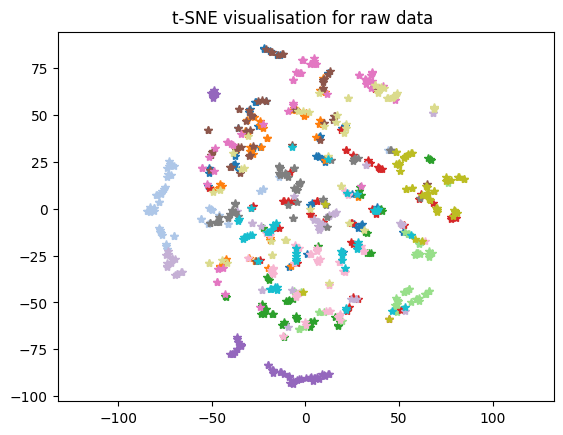

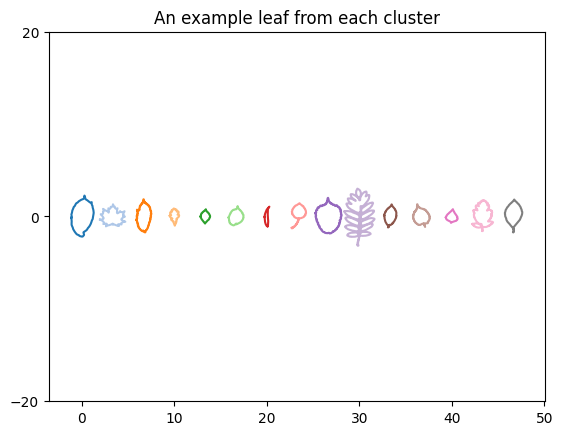

In [17]:
#load the training set of contours
path = r'C:\Users\user1\Documents\geom learning\article\training_set.mat'
training = scipy.io.loadmat(path)
training_set = training['etape0']

print('Dunn index for raw training data = ', dunn_index(training_set))

cluster_visualisation(training_set, 'raw data', 20, 500)

### b. Standardizing the starting point of the parameterization

The first standardization step is making sure the first point in the parameterization of each contour in the set is the northernmost point, i.e. the point in the parameterization with the highest vertical component (y-coordinate). We compute the Dunn index for the set contours after this step to see what changes. 

Dunn index after standardizing the starting point =  0.0317988338721205


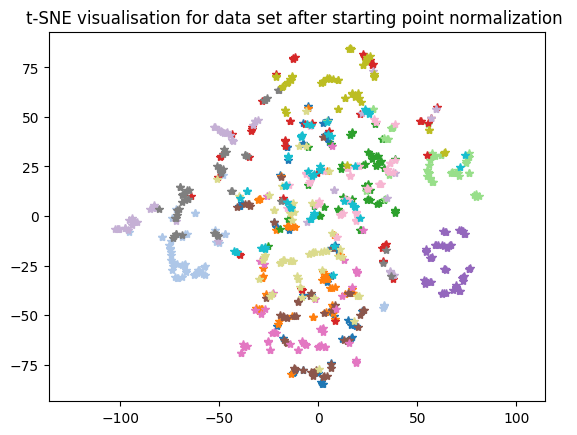

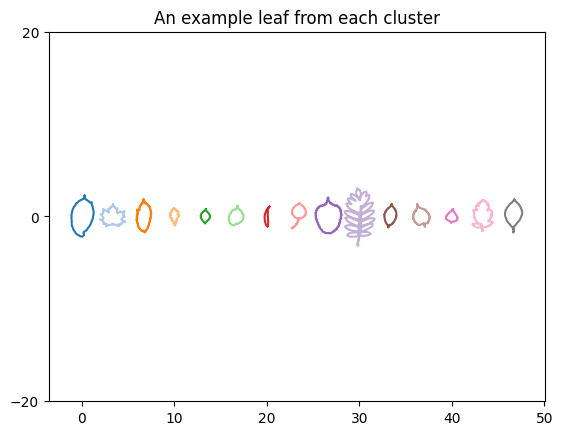

In [19]:
training_set_start = np.zeros(np.shape(training_set))

for i in range(np.shape(training_set)[0]):
    training_set_start[i, :, :] = get_max_y_and_roll(training_set[i, :, :])

print('Dunn index after standardizing the starting point = ', dunn_index(training_set_start))

cluster_visualisation(training_set_start, 'data set after starting point normalization', 20, 500)

We remark that the Dunn index has incresead. As a higher Dunn index is correlated with a better separation of clusters, we continue on with the `training_set_start` set. 

### c. Standardizing the scale variability

We test two normalization procedures here: the normalization of the length of contours and the normalization of the enclosed contour. We compute the Dunn index for the set after it undergoes each of these transformations and chose the option that yields the highest Dunn index. 

Dunn index after normalizing length =  0.05588900544730925
Dunn index after normalizing area =  0.038783361471005834


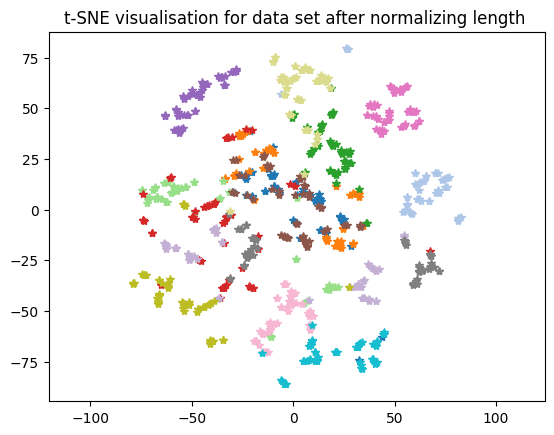

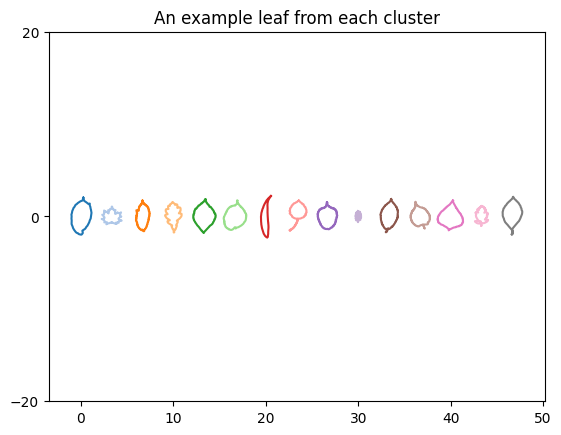

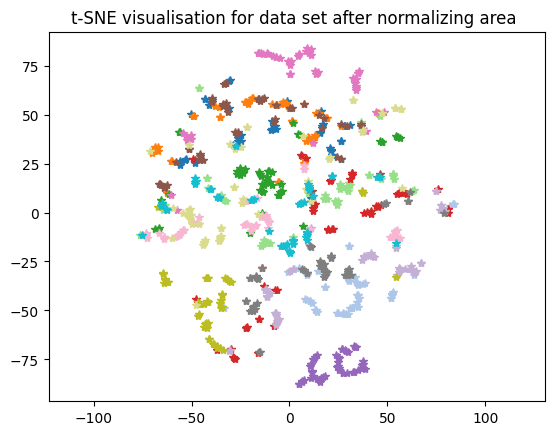

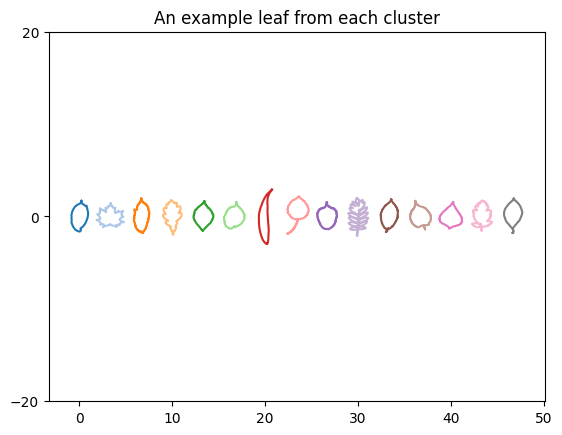

In [20]:
training_unit_length = np.zeros(np.shape(training_set_start))
training_unit_area = np.zeros(np.shape(training_set_start))

for i in range(np.shape(training_set_start)[0]):
    training_unit_length[i, :, :] = curve_unit_length(training_set_start[i, :, :])
    training_unit_area[i, :, :] = scale_unit_area(training_set_start[i, :, :])

print('Dunn index after normalizing length = ', dunn_index(training_unit_length))
print('Dunn index after normalizing area = ', dunn_index(training_unit_area))

cluster_visualisation(training_unit_length, 'data set after normalizing length', 20, 0.1)
cluster_visualisation(training_unit_area, 'data set after normalizing area', 20, 0.5)

We remark that the Dunn index is higher after normalizing the length. Therefore, we continue on with the dataset `training_unit_length`. 

### d. Standardizing the position in space

This normalization step is achieved by translating the contours to the origin of the plane. We tested three normalizations procedures: the origin is the starting point, the origin is the center of mass of the contour and the origin is the center of mass of the surface of the leaf (i.e. the center of the gravity). We compute the Dunn index after each of these steps and proceed from the step that yields the highest Dunn index. 

Dunn index after centering at the starting point =  0.048168299482015065
Dunn index after centering at the center of mass on the contour =  0.05394694665945235
Dunn index after centering at the center of gravity =  0.05588900544730925


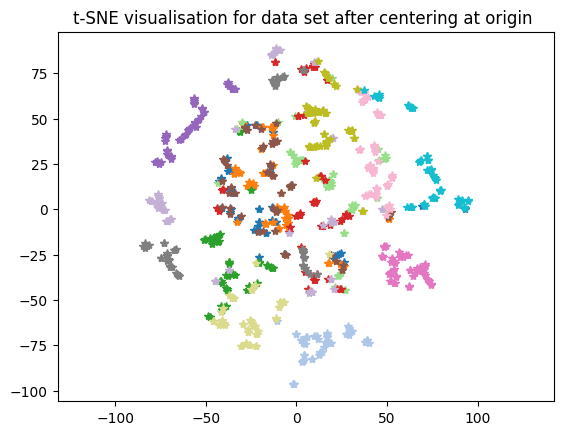

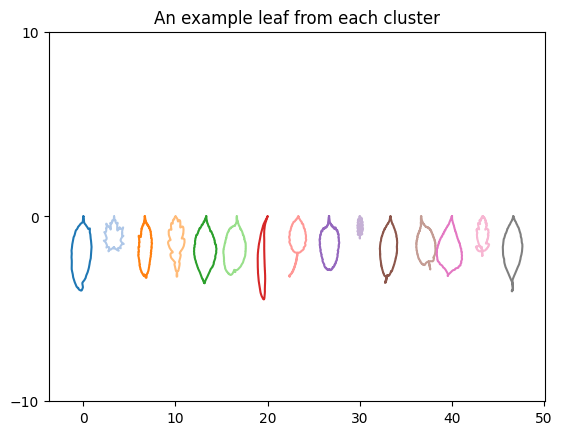

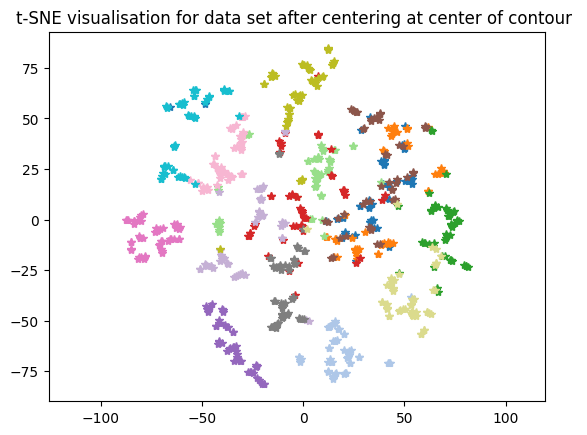

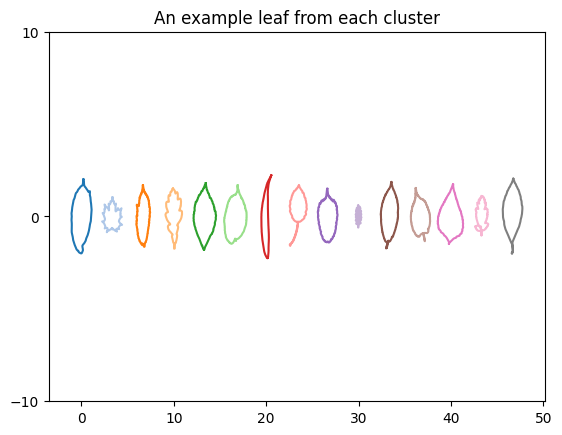

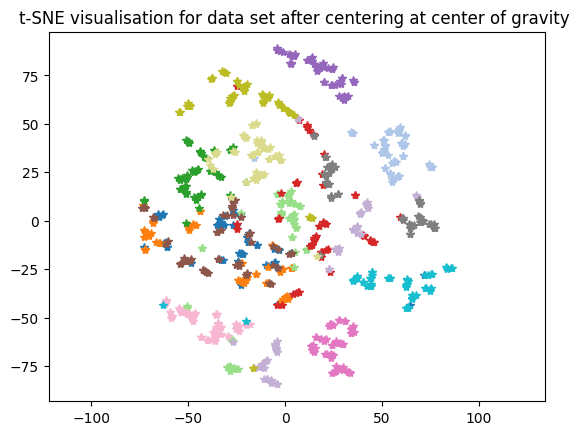

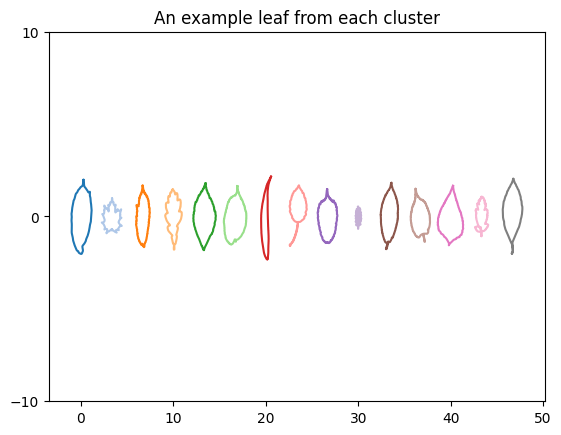

In [21]:
training_origin = np.zeros(np.shape(training_unit_length))
training_mass_contour = np.zeros(np.shape(training_unit_length))
training_gravity = np.zeros(np.shape(training_unit_length))

for i in range(np.shape(training_unit_length)[0]):
    #get the starting point of the contour
    center1 = gs.array([training_unit_length[i, 0, 0], training_unit_length[i, 0, 1]])
    training_origin[i, :, :] = training_unit_length[i, :, :] - center1

for i in range(np.shape(training_unit_length)[0]):
    #compute the center of mass of the contour
    center2 = gs.array([np.mean(training_unit_length[i, :, 0]), np.mean(training_unit_length[i, :, 1])])
    training_mass_contour[i, :, :] = training_unit_length[i, :, :] - center2

for i in range(np.shape(training_unit_length)[0]):
    #compute the center of gravity
    center3 = compute_center_of_mass(training_unit_length[i, :, :])
    training_gravity = training_unit_length - center3
    
print('Dunn index after centering at the starting point = ', dunn_index(training_origin))
print('Dunn index after centering at the center of mass on the contour = ', dunn_index(training_mass_contour))
print('Dunn index after centering at the center of gravity = ', dunn_index(training_gravity))

cluster_visualisation(training_origin, 'data set after centering at origin', 10, 0.1)
cluster_visualisation(training_mass_contour, 'data set after centering at center of contour', 10, 0.1)
cluster_visualisation(training_gravity, 'data set after centering at center of gravity', 10, 0.1)

We remark that the Dunn index after centering at the center of gravity is the highest, so we continue with the dataset `training_gravity`. 

### e. Standardizing the orientation in space

We have tested two normalization procedures to align the orientations through the dataset. For the first one, we align the axes of the approximated ellipse. For the second one, we rotate the contours such that the segment joining the tip of the leaf to the center of the enclosed area is placed vertically. We compute the Dunn index in each case and proceed from that step that yielded the highest Dunn index. 

Dunn index after aligning ellipse axes =  0.023115901926822505
Dunn index after aligning vertical vector =  0.06362767555526606


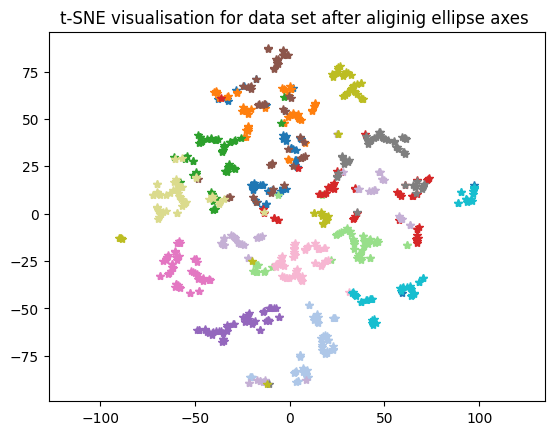

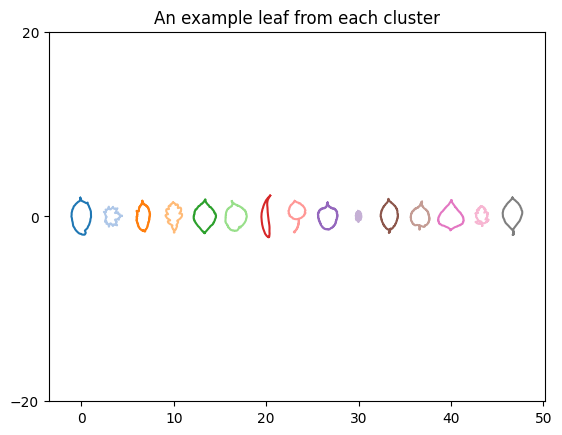

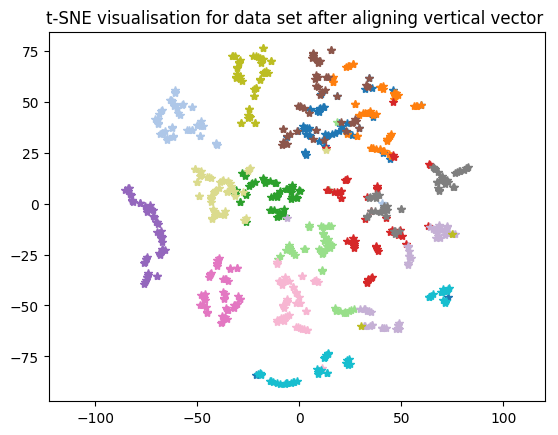

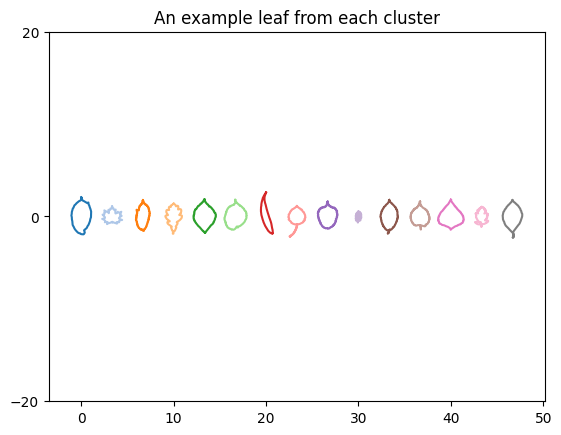

In [22]:
training_ellipse = np.zeros(np.shape(training_gravity))
training_vertical = np.zeros(np.shape(training_gravity))

for i in range(np.shape(training_gravity)[0]):
    training_ellipse[i, :, :] = rotate_curve_major_vertical(training_gravity[i, :, :])
    training_vertical[i, :, :] = rotate_axis(training_gravity[i, :, :])
    
print('Dunn index after aligning ellipse axes = ', dunn_index(training_ellipse))
print('Dunn index after aligning vertical vector = ', dunn_index(training_vertical))

cluster_visualisation(training_ellipse, 'data set after aliginig ellipse axes', 20, 0.1)
cluster_visualisation(training_vertical, 'data set after aligning vertical vector', 20, 0.1)

We remark that we've obtained the highest Dunn index when we the procedure used for aligning the contours was aligning by the vertical vector. Therefore, we proceed with the dataset `training_vertical`. 

### f. Clock parameterization

Next, we investigate the effect of different reparameterization on the clustering efficency. For this purpose, we use the clock reparameterization from Section 3 with different parameters. However, there are some problematic leaves in the dataset, namely the leaves for which the center of mass of the surface lies outside the contour. Before reparameterizing using the clock parameterization, we have to rectify this issue. The code below shows one way to do this. 

First, we find out who the problematic leaves are. 

In [24]:
#we use the function for a dataset of contours that have been translated such that their center of gravity is at the point (0,0)
def findProblematicLeaves(mydataset) -> np.array:
    indices = np.zeros(np.shape(mydataset)[0])
    for i in range(np.shape(mydataset)[0]):
        shape = mpltPath.Path(mydataset[i, :, :])
        #we test to see if the point (0, 0) lies inside the area enclosed by the contour
        #if not, we record the index of this contour
        if shape.contains_point([0,0]) is False:
            indices[i] = i
    return indices

path = r'C:\Users\user1\Documents\geom learning\article\training_set.mat'
dataset = scipy.io.loadmat(path)
data = dataset['etape0']

#the number of points in the parameterization
N = 1000
contours = np.zeros((np.shape(data)[0], N, np.shape(data)[2]))

for i in range(np.shape(data)[0]):
    leaf = data[i, :, :]
    #perform the normalization steps that yield the highest Dunn index
    arc_leaf = reparametrize_by_arc_length(leaf, N)
    arc_leaf = get_max_y_and_roll(arc_leaf)
    arc_leaf = curve_unite_length(arc_leaf)
    arc_leaf = translate_center_of_mass(arc_leaf)
    arc_leaf = rotate_axis(arc_leaf)
    contours[i, :, :] = arc_leaf

problematic_leaves = findProblematicLeaves(contours)


Furthermore, we center the problematic leaves at a point close to the point $(0,0)$ that lies within the area enclosed by the contour. 

In [25]:
#A function that receives three points and computes the center of gravity of the triangle they define
def findCentroid(A, B, C):
    x = (A[0] + B[0] + C[0]) / 3
    y = (A[1] + B[1] + C[1]) / 3
    G = np.array([x, y])
    return G

def fixProblematicLeaves(leaf, visualise = False) -> np.array:
    #Find the closest point to origin located on the contour of the curve
    distances = np.linalg.norm(leaf, axis = 1)
    C = leaf[np.argmin(distances)]

    path = mpltPath.Path(leaf)
    i = 1
    #point to the left of C (with respect to the orientation)
    A = leaf[np.argmin(distances) + i]
    #point to the right of C (with respect to the orientation)
    B = leaf[np.argmin(distances) - i]

    #test to see if the points A, B, C can form a triangle
    if np.linalg.det(np.array([[A[0], A[1], 1], [B[0], B[1], 1], [C[0], C[1], 1]])) != 0:
        #if they can form a triangle, compute its center of gravity
        G = findCentroid(A, B, C)

    #if G is INSIDE the shape, this next part is skipped
    #if G is NOT INSIDE the shape, then
    #fix A and change B
    A1 = A
    B1 = B
    G1 = G
    while path.contains_point(G1) is False:
        i += 1
        B1 = leaf[np.argmin(distances) - i]
        if np.linalg.det(np.array([[A1[0], A1[1], 1], [B1[0], B1[1], 1], [C[0], C[1], 1]])) != 0:
            G1 = findCentroid(A1, B1, C)
    
    #fix B and change A
    A2 = A
    B2 = B
    G2 = G
    while path.contains_point(G2) is False:
        i += 1
        A2 = leaf[np.argmin(distances) + i]
        if np.linalg.det(np.array([[A2[0], A2[1], 1], [B2[0], B2[1], 1], [C[0], C[1], 1]])) != 0:
            G2 = findCentroid(A2, B2, C)

    #find out which point between G1 and G2 is closer to C and translate the curve accordingly
    if np.linalg.norm(C - G1) < np.linalg.norm(C - G2):
        fixed_leaf = leaf - G1
    else:
        fixed_leaf = leaf - G2

    #this section of the code plots the original curve and the translate curve for debugging purposes
    if visualise:
        plt.plot(leaf[:, 0], leaf[:, 1], label = 'original curve') 
        plt.plot(fixed_leaf[:, 0], fixed_leaf[:, 1], label = 'translated curve')
        plt.plot(0, 0, '.', color = 'red')
        plt.plot(C[0], C[1], '.', color = 'blue')
        plt.plot(A[0], A[1], '.', color = 'green')
        plt.plot(B[0], B[1], '.', color = 'green')
        plt.plot(G[0], G[1], '.', color = 'yellow')
        plt.plot(G1[0], G1[1], '.', color = 'pink')
        plt.plot(G2[0], G2[1], '.', color = 'pink')
        plt.axis('equal')
        plt.show()

    return fixed_leaf

for i in range(np.shape(problematic_leaves)[0]):
    if problematic_leaves[i] != 0:
        contours[int(problematic_leaves[i]), :, :] = fixProblematicLeaves(contours[int(problematic_leaves[i])])

Now, reparameterize every contour using the clock parameterization. The number of points in the initial parameterization must be divisible by the number of subdivisions. The parameter $\lambda$ represents the weight of the curvature in the clock parameterization. If $\lambda = 0$, then we get a parameterization proportional with the curvature, if $\lambda \to \infty$, then we get the arc length parameterization.   

Dunn index after reparameterization by the clock parameterization (lambda = 0):  0.06303841424752236


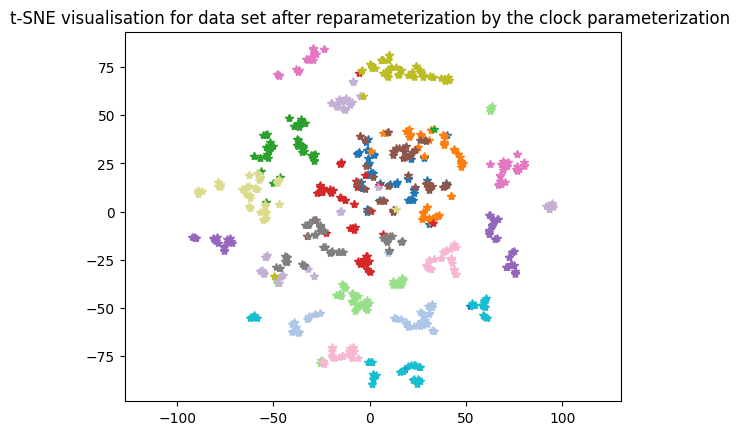

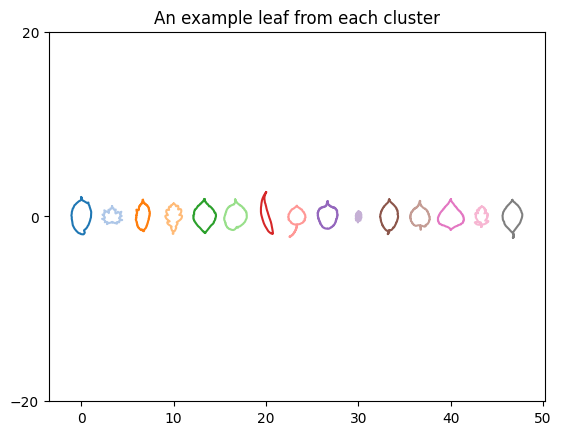

Dunn index after reparameterization by the clock parameterization (lambda = 100): =  0.058031778171019725


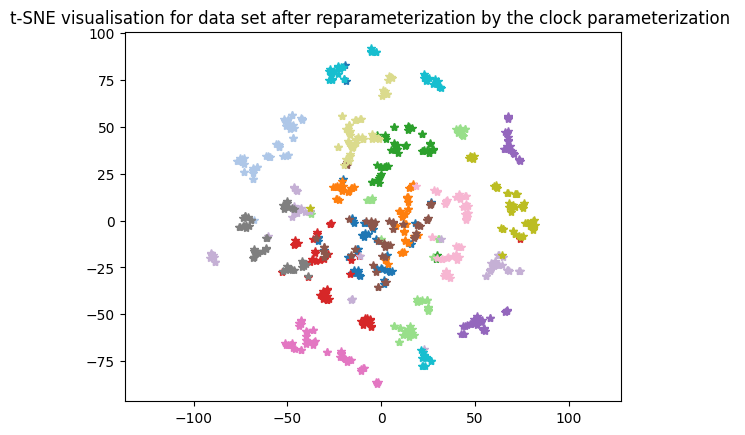

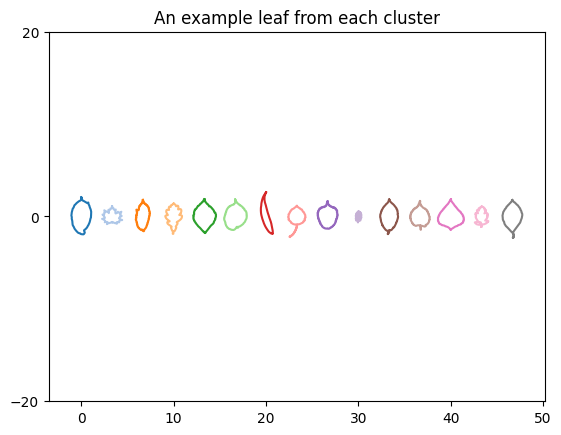

Dunn index after reparameterization by the clock parameterization (lambda = 2000)=  0.060427621017908426


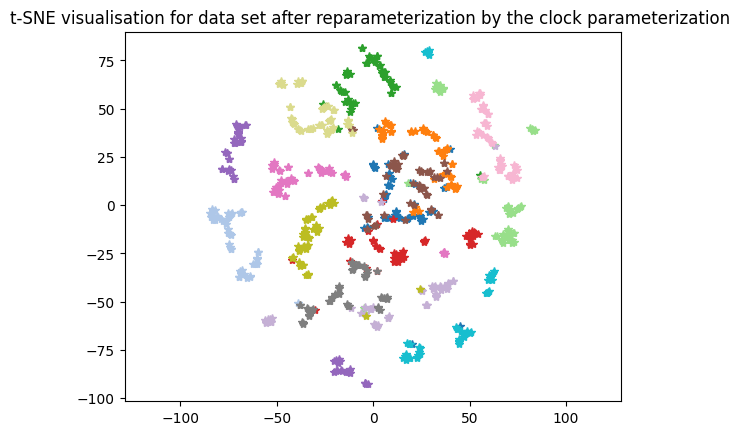

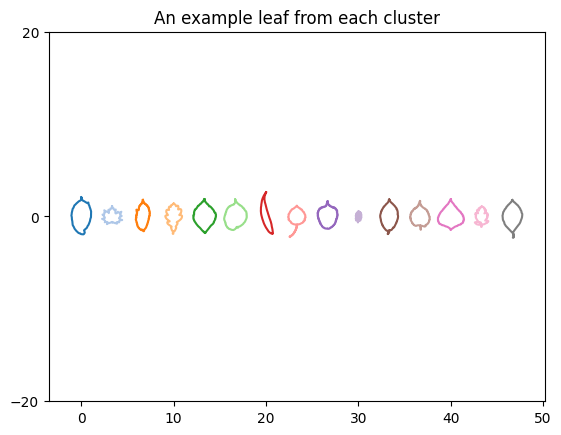

In [26]:
#we test three different reparameterization corresponding to three different values of lambda
clock_contours1 = np.zeros(np.shape(contours))
clock_contours2 = np.zeros(np.shape(contours))
clock_contours3 = np.zeros(np.shape(contours))

for i in range(np.shape(contours)[0]):
    #lambda = 0
    test_clock = projection_clock_a_lmbda(contours[i, :, :], n_subdivision = 10, lmbda = None, visualize = False)
    clock_contours1[i, :, :] = test_clock
    #lambda = 100
    _,test_clock = projection_clock_a_lmbda(contours[i, :, :], n_subdivision = 10, lmbda = 100, visualize = False)
    clock_contours2[i, :, :] = test_clock
    #lambda = 2000
    _,test_clock = projection_clock_a_lmbda(contours[i, :, :], n_subdivision = 10, lmbda = 2000, visualize = False)
    clock_contours3[i, :, :] = test_clock


print('Dunn index after reparameterization by the clock parameterization (lambda = 0): ', dunn_index(clock_contours1))
cluster_visualisation(clock_contours1, 'data set after reparameterization by the clock parameterization', 20, 0.1)

print('Dunn index after reparameterization by the clock parameterization (lambda = 100): = ', dunn_index(clock_contours2))
cluster_visualisation(clock_contours2, 'data set after reparameterization by the clock parameterization', 20, 0.1)

print('Dunn index after reparameterization by the clock parameterization (lambda = 2000)= ', dunn_index(clock_contours3))
cluster_visualisation(clock_contours3, 'data set after reparameterization by the clock parameterization', 20, 0.1)

